# Example of how to use a snaphsot from the Eagle
# simulations to download the particles information
# necessary to run the iMaStar code 

### !!! Here, we used the smallest run of the Eagle simulations and the snapshot at z=0
### !!! This snapshot can be downloaded here, once you have an Eagle account:
### https://dataweb.cosma.dur.ac.uk:8443/eagle-snapshots/
### RefL0012N0188 at z=0.0

In [1]:


import h5py
import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt 
from read_dataset import read_dataset 
#modified from the script presented here 
#https://arxiv.org/pdf/1706.09899.pdf
from read_header import read_header 
#modified from the script presented
#here https://arxiv.org/pdf/1706.09899.pdf

import astropy.cosmology as co
cosmo = co.Planck15
from tqdm import tqdm

## In Table 6 here https://arxiv.org/pdf/1706.09899.pdf there is the description for the stellar particles information

In [2]:
def read_galaxy(itype, gn, sgn, z):
    """ Selecting a galaxy defining GroupNumber and SubGroupNumber,
        extract the info necessary to run the iMaStar code
        it can be modified to extract other particle info
        
        !!! periodicity of the box is not accounted for in this script !!!
        
        !!! The snapshot can be changed modifying the path for the snapshot 
        declared in read_dataset and read_header
    """

    data = {}
    a, h, boxsize = read_header()

    # Load data, then mask to selected GroupNumber and SubGroupNumber.
    gns  = read_dataset(itype, 'GroupNumber')
    sgns = read_dataset(itype, 'SubGroupNumber')
    mask = np.logical_and(gns == gn, sgns == sgn)
    
    coords = read_dataset(itype, 'Coordinates')[mask] * u.cm.to(u.pc)
    mass = read_dataset(itype, 'InitialMass')[mask] * u.g.to(u.Msun)
    
    xcm = (np.sum(coords[:,0]*mass)/np.sum(mass))
    ycm = (np.sum(coords[:,1]*mass)/np.sum(mass))
    zcm = (np.sum(coords[:,2]*mass)/np.sum(mass))
    #here we define the centre of mass of the stellar particles to center the 
    #system of reference to the centre of mass
    
    data['coords'] = [coords[:,0]-xcm, coords[:,1]-ycm, coords[:,2]-zcm] #pc

    data['mass'] = mass #Msun
    
    data['met'] = read_dataset(itype, 'Metallicity')[mask] # [Z/H]
    
    SFT = read_dataset(itype, 'StellarFormationTime')[mask] 
    
    RedStar = (1-SFT)/SFT

    eta = cosmo.lookback_time(RedStar)
    eta_galaxy = np.asarray(cosmo.lookback_time(z))

    Eta = np.asarray(eta) - eta_galaxy

    data['age'] = Eta #Gyr
    
    
    data['velocity'] = read_dataset(itype, 'Velocity')[mask] *a* u.cm.to(u.km) #km/s


    return data

In [3]:
# parttype = 4 --> stellar particle
# groupnum --> group id in the snapshot selected
#subhalonum --> galaxy id in the groupd selected
# redshift --> redshift assumed to observe the galaxy
parttype, groupnum, subhalonum, redshift = 4, 1, 0, 0.03 

In [4]:
galaxy_dataset = read_galaxy(parttype, groupnum, subhalonum, redshift)

In [5]:
x = galaxy_dataset['coords'][0] #pc
y = galaxy_dataset['coords'][1] #pc
z = galaxy_dataset['coords'][2] #pc

Mstar = galaxy_dataset['mass'] #Msun
Zin = galaxy_dataset['met'] #[Z/H]
tin = galaxy_dataset['age'] #Gyr
velx = galaxy_dataset['velocity'][:,0] #km/s
vely = galaxy_dataset['velocity'][:,1] #km/s
velz = galaxy_dataset['velocity'][:,2] #km/s

In [6]:
dist_A = cosmo.luminosity_distance(redshift) #distance of the mock IFU instrument
theta_spaxel = 0.5*u.arcsec # resolution of the mock IFU instrument in arcsec

# resolution of the mock IFU instrument in pc:
l_spaxel = (theta_spaxel * dist_A).to(u.pc, u.dimensionless_angles()) 
cdelt = float(np.array(l_spaxel.copy()))


n_pixel = 50 #number of pixel of the mock IFU
FoV = n_pixel * np.asarray(l_spaxel) #FoV of the mock IFU

#defining the grid of the IFU pixel
x_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)
y_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)
z_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)



## MaStar

In [7]:
import iMaStar_functions as imastar


In [8]:
x_bin_id_list = np.digitize(x[tin>10**-3], x_edge)
y_bin_id_list = np.digitize(y[tin>10**-3], y_edge)
z_bin_id_list = np.digitize(z[tin>10**-3], z_edge)

In [9]:
    arr = np.zeros((4563,n_pixel,n_pixel))
    std_vz = np.zeros((n_pixel,n_pixel))

    for i in tqdm(range(n_pixel)):
        for j in range(n_pixel):
            arr[:,i,j], std_vz[i,j] = imastar.bin_spectrum(redshift, Mstar[tin>10**-3], Zin[tin>10**-3], tin[tin>10**-3], velx[tin>10**-3], y_bin_id_list,z_bin_id_list, i+1, j+1)

100%|███████████████████████████████████████████| 50/50 [00:35<00:00,  1.42it/s]


In [10]:
import matplotlib as mpl


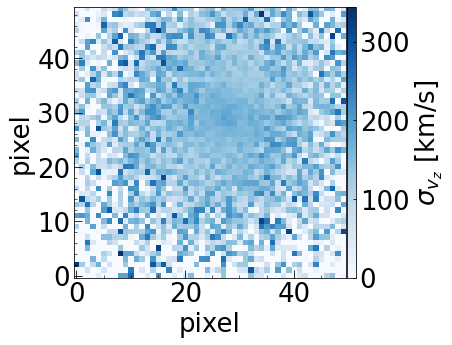

In [11]:
fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=26)
ax.tick_params(length=3, which='minor', direction="in", labelsize=26)


im = plt.imshow(std_vz[:,:].T, cmap= mpl.cm.Blues)

cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.tick_params(labelsize=26, axis='y', direction='in')
cbar.set_label('$\sigma_{v_z}$ [km/s]',fontsize=26);


plt.xlabel(r'pixel', fontsize=26) #micron
plt.ylabel(r'pixel', fontsize=26) #micron


plt.gca().invert_yaxis()





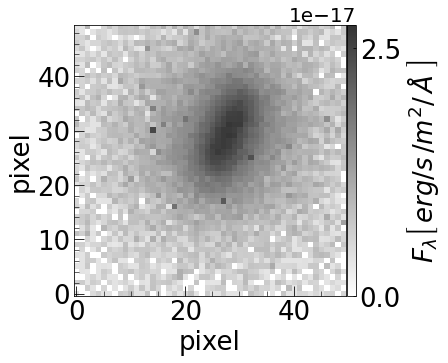

In [12]:
from astropy.visualization import simple_norm
fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)


im = ax.imshow(arr[2419, :,:].T, cmap="gray_r", alpha=0.8,  interpolation="nearest", origin='lower', norm=simple_norm(arr[2000, :,:].T, stretch='log', log_a=1000))


cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.locator_params(nbins=2)
ttt = cbar.ax.yaxis.get_offset_text()

cbar.ax.tick_params(labelsize=26, axis='y', direction='in')

cbar.set_label(r'$ F_\lambda\left[\,erg/s \,/m^2/\,\AA \,\,\right]$',fontsize=26);

plt.xlabel(r'pixel', fontsize=26) #micron
plt.ylabel(r'pixel', fontsize=26) #micron
ttt.set_size(20)
